# build molecule, taper and construct CS-VQE model

In [4]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [5]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [6]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'ZZX', 'IXI', 'ZXZ', 'IXX', 'IYY', 'XII', 'XZZ', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j]), coeff=1.0)

In [7]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

#ucc_trunc = ucc_cs#.sort()[:40]
#anz_cs = AnsatzOp(ucc_trunc.symp_matrix, ucc_trunc.coeff_vec)

#obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
#vqe_result = obs.VQE(
#    ansatz_op=anz_cs, 
#    ref_state=ref_cs
#)

#opt_params = vqe_result[0]['x']
#vqe_result[0]['fun'] - molecule.fci_energy

In [8]:
from qiskit import QuantumCircuit
ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz = ansatz.compose(anz_cs.to_QuantumCircuit(bind_params=False))
ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░                                       ░             └───┘┌─┴─┐»
q_2: ─░───────────────────────────────────────░──────────────────┤ X ├»
      ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [9]:
#from qiskit.quantum_info import Statevector
#from symmer.symplectic import QuantumState
#qc = ansatz.bind_parameters(opt_params)
#psi = Statevector.from_instruction(qc).to_dict()
#state_matrix, coeff_vec = zip(*[([int(i) for i in bstring], coeff) for bstring, coeff in psi.items()])
#state_matrix = np.array(state_matrix)
#coeff_vec = np.array(coeff_vec)

#psi = QuantumState(state_matrix, coeff_vec)
#psi.conjugate * ham_cs * psi - molecule.fci_energy

In [12]:
from qiskit.circuit.library import EfficientSU2
ansatz = EfficientSU2(n_qubits)#, reps=1)
ansatz.decompose().draw()

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├»
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤»
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├»
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘»
«               ┌───────────┐┌───────────┐                       ┌───────────┐»
«q_0: ──■────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■────■──┤ Ry(θ[18]) ├»
«     ┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │  └───────────┘»
«q_1: ┤ X ├──┼────────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──┼────────■──────»
«     └───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    »
«q_2: ─────┤ X ├────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────┤ X ├────┤ X ├────»
«          └───┘    └───┘    └───────────┘└───────────┘     └───┘    └───┘    »
«     ┌───────────┐             
«q_0: ┤ Rz(θ[21]) ├─────────────
«     ├───────────┤┌───────────┐
«q_1: ┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├
«     ├───────────┤├───────────┤
«q_2: ┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├
«     └───────────┘└───────────┘

In [13]:
#import qiskit.circuit.library.n_local as lib_local

#ansatz = getattr(lib_local, "EfficientSU2")
#ansatz(3).decompose().draw()

# VQE using ``symmer-vqe-Ve6OdoVd8X`` runtime program

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [15]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'

In [17]:
#service.update_program(program_id=program_id, data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
# service.delete_program(program_id) # to delete program

In [18]:
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [19]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [20]:
#for name in service.backends():
#    print(f'Backend name: {name.name: <29} | '+
#          f'Number of qubits: {name.num_qubits: <4} | '+
#          f'Number of jobs queued: {name.status().pending_jobs}'
#    )

In [21]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

#excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
excitation_circuit = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=2, insert_barriers=True)

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.decompose().draw()

░ ┌──────────┐┌──────────┐ ░ ┌───┐           ░ ┌──────────┐ ┌──────────┐»
q_0: ─░─┤ Rx(θ[0]) ├┤ Ry(θ[3]) ├─░─┤ X ├──■────────░─┤ Rx(θ[6]) ├─┤ Ry(θ[9]) ├»
      ░ ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐      ░ ├──────────┤┌┴──────────┤»
q_1: ─░─┤ Rx(θ[1]) ├┤ Ry(θ[4]) ├─░───┼──┤ X ├──■───░─┤ Rx(θ[7]) ├┤ Ry(θ[10]) ├»
      ░ ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐ ░ ├──────────┤├───────────┤»
q_2: ─░─┤ Rx(θ[2]) ├┤ Ry(θ[5]) ├─░───■───────┤ X ├─░─┤ Rx(θ[8]) ├┤ Ry(θ[11]) ├»
      ░ └──────────┘└──────────┘ ░           └───┘ ░ └──────────┘└───────────┘»
«      ░ ┌───┐           ░ ┌───────────┐┌───────────┐
«q_0: ─░─┤ X ├──■────────░─┤ Rx(θ[12]) ├┤ Ry(θ[15]) ├
«      ░ └─┬─┘┌─┴─┐      ░ ├───────────┤├───────────┤
«q_1: ─░───┼──┤ X ├──■───░─┤ Rx(θ[13]) ├┤ Ry(θ[16]) ├
«      ░   │  └───┘┌─┴─┐ ░ ├───────────┤├───────────┤
«q_2: ─░───■───────┤ X ├─░─┤ Rx(θ[14]) ├┤ Ry(θ[17]) ├
«      ░           └───┘ ░ └───────────┘└───────────┘

In [22]:
2**14

16384

In [241]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": np.zeros(ansatz.num_parameters),
    "optimizer": 'SLSQP',
    "n_groups":5,
    "opt_setting": {"maxiter":10, "gtol": 1e-6},
    "n_shots": 2**13, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":5
}

In [242]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [243]:
#service.backend(backend_name).status()

In [246]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: casovg3e68ooh09r3fig
Job status: JobStatus.RUNNING


In [272]:
print(molecule.hf_energy, molecule.fci_energy)
job.interim_results()

-14.351880476202023 -14.403655108067682


['Optimization step #18: energy = -14.402772151763525',
 'VQE complete',
 'Optimization step #17: energy = -14.403753562802896',
 'Optimization step #16: energy = -14.401595758181756',
 'Optimization step #15: energy = -14.404786679395249',
 'Optimization step #14: energy = -14.400303948807164',
 'Optimization step #13: energy = -14.392153213181132',
 'Optimization step #12: energy = -14.400704519081945',
 'Optimization step #11: energy = -14.39456450167306',
 'Optimization step #10: energy = -14.40305523086125',
 'Optimization step #9: energy = -14.397757253813632',
 'Optimization step #8: energy = -14.381760695180162',
 'Optimization step #7: gradient norm = 0.11860087357455545',
 'Optimization step #7: energy = -14.40586215320992',
 'Optimization step #6: energy = -14.387954314521973',
 'Optimization step #5: gradient norm = 0.11600758751423443',
 'Optimization step #5: energy = -14.401608258264664',
 'Optimization step #4: energy = -14.397248986626229',
 'Optimization step #3: grad

In [273]:
vqe_result, interim_values = job.result()

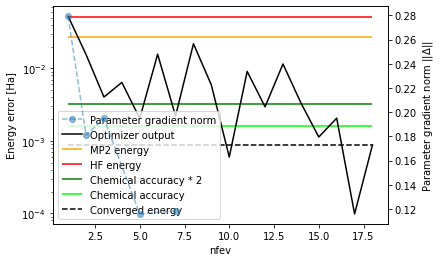

In [274]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()

# program metadata

In [2]:
meta = {
    "name": "symmer_vqe",
    "description": "VQE program using symmer",
    "max_execution_time": 100000,
    "spec": {},
}

In [3]:
meta["spec"]["parameters"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "properties": {
        "ansatz": {
            "description": "Parametrized Ansatz",
            "type": "QuantumCircuit",
        },
        "observable_groups": {
            "description": "Decomposition of operator into groups, e.g. qubit-wise commuting",
            "type": "List[Union[PauliSumOp, PauliOp]]",
            "default": "None"
        },
        "observable": {
            "description": "The observable on which we wish to perform eigenvalue estimation",
            "type": "PauliSumOp",
            "default": "None",
        },
        "opt_setting": {
            "description": "Optimizer settings",
            "type": "dict",
            "default": "{'maxiter':10}",
        },
        "init_params": {
            "description": "Initial vector of parameters. This is a numpy array.",
            "type": "array",
            "default": "None",
        },
        "n_shots": {
            "description": "The number of shots used for each circuit evaluation.",
            "type": "integer",
            "default": "2**12",
        },
        "n_realize": {
            "description": "The number of realizations of each energy estimation - these are averaged over.",
            "type": "integer",
            "default": "1",
        },
        "n_groups": {
            "description": "The number of classical shadow groups.",
            "type": "integer",
            "default": "5",
        },
        "mitigate_errors": {
            "description": "Use matrix-free measurement mitigation (mthree), default=False.",
            "type": "boolean",
            "default": "False",
        },
    },
    "required": ["ansatz"],
}

meta["spec"]["return_values"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Tuple of final result in SciPy optimizer format and dictionary of interim values",
    "type": "Tuple[scipy.optimize.optimize.OptimizeResult, Dict]",
}

meta["spec"]["interim_results"] = {
    "$schema": "https://json-schema.org/draft/2019-09/schema",
    "description": "Parameter vector at current optimization step. This is a numpy array.",
    "type": "array",
}